Neuron 20
mean response on animal images:     0.08
mean response on non-animal images: 0.030099009900990098
difference (animal - non-animal):   0.049900990099009904
X shape: (118, 39209)
y shape: (118,)  | proportion animals: 0.5338983050847458


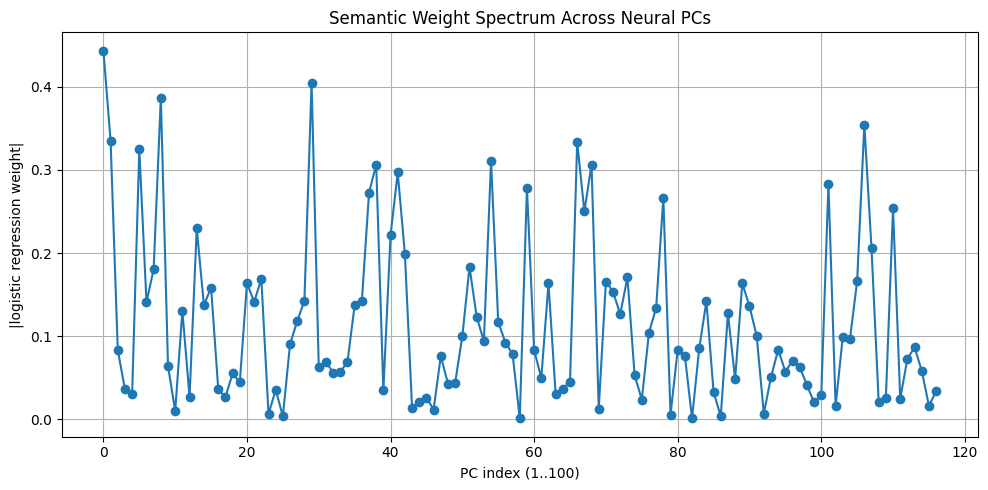


Top semantic PCs (with weights):
PC 1:  |w|=0.4431
PC 30:  |w|=0.4048
PC 9:  |w|=0.3868
PC 107:  |w|=0.3541
PC 2:  |w|=0.3348
PC 67:  |w|=0.3333
PC 6:  |w|=0.3246
PC 55:  |w|=0.3104
PC 39:  |w|=0.3064
PC 69:  |w|=0.3062


In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'  


# Load data
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH)            # shape: (images, neurons)
areas = np.load(AREAS_PATH, allow_pickle=True)         # shape: (neurons,)
# vit: (n_images, 1000)
# R:   (n_images, n_neurons)

pos_classes = [
    291, 274, 288, 293, 271, 292, 290, 272, 269, 280,
    286, 275, 276, 294, 289, 273, 270, 287, 278, 371,
]

neg_classes = [
    421, 879, 412, 716, 703, 637, 818, 883, 489, 898,
    880, 733, 706, 523, 738, 616, 448, 696, 704, 506,
]

animal_set = set(pos_classes)  # “predator-ish” classes

top1 = np.argmax(vit, axis=1)  # top-1 ImageNet class per image

# Binary semantic feature: 1 = animal-ish, 0 = non-animal-ish
animal_feat = np.isin(top1, list(animal_set)).astype(float)   # shape: (n_images,)

neuron_idx = 20
y = R[neuron_idx,:]   # neural average event probs for each image

animal_mask = animal_feat == 1
non_mask    = animal_feat == 0

mu_animal = y[animal_mask].mean()
mu_non    = y[non_mask].mean()
effect    = mu_animal - mu_non

print("Neuron", neuron_idx)
print("mean response on animal images:    ", mu_animal)
print("mean response on non-animal images:", mu_non)
print("difference (animal - non-animal):  ", effect)


# --------------------------------------------------------
# 1. Data preparation
# --------------------------------------------------------
# R: neurons x images  →  X: images x neurons
X = R.T.astype(float)        # shape (118, 39209)
top1 = np.argmax(vit, axis=1)
y = (top1 <= 397).astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape, " | proportion animals:", y.mean())

# --------------------------------------------------------
# 2. Fit PCA + Logistic on ALL data (analysis-only model)
# --------------------------------------------------------
pca_dim = 117

pipe = Pipeline([
    ("pca", PCA(n_components=pca_dim, svd_solver='randomized')),
    ("clf", LogisticRegression(
        penalty='l2', C=0.1, solver='liblinear', max_iter=500
    ))
])

pipe.fit(X, y)

# Extract components
pca = pipe.named_steps["pca"]
clf = pipe.named_steps["clf"]

weights = clf.coef_[0]           # shape (100,)
abs_weights = np.abs(weights)

# --------------------------------------------------------
# 3. Plot semantic weight spectrum
# --------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(abs_weights, marker='o')
plt.title("Semantic Weight Spectrum Across Neural PCs")
plt.xlabel("PC index (1..100)")
plt.ylabel("|logistic regression weight|")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also print ranked PCs
sorted_idx = np.argsort(abs_weights)[::-1]
print("\nTop semantic PCs (with weights):")
for i in range(10):
    print(f"PC {sorted_idx[i]+1}:  |w|={abs_weights[sorted_idx[i]]:.4f}")


In [4]:
from sklearn.metrics import log_loss

# predicted probability of class 1
proba_pos = pipe.predict_proba(X)[:, 1]    # shape (118,)

# scikit's log_loss is exactly the average NLL (natural log by default)
avg_nll_nat = log_loss(y, proba_pos)       # in nats (ln)
total_nll_nat = avg_nll_nat * len(y)

import numpy as np

avg_nll_bits = avg_nll_nat / np.log(2)
total_nll_bits = total_nll_nat / np.log(2)
print("Avg NLL (bits per label):", avg_nll_bits)
print("Total NLL (bits for all labels):", total_nll_bits)



Avg NLL (bits per label): 0.22821624930071208
Total NLL (bits for all labels): 26.92951741748403


In [5]:
from sklearn.metrics import log_loss
import numpy as np

proba_pos = pipe.predict_proba(X)[:, 1]
avg_nll_nat = log_loss(y, proba_pos)
avg_nll_bits = avg_nll_nat / np.log(2)

p = y.mean()
H_y = -(p*np.log2(p) + (1-p)*np.log2(1-p))

print("Baseline label entropy H(Y) (bits):", H_y)
print("Avg NLL given PCs (bits/label):    ", avg_nll_bits)
print("Estimated I(Y;Z) ≈ H(Y) - H(Y|Z):  ", H_y - avg_nll_bits)


Baseline label entropy H(Y) (bits): 0.9966818677995445
Avg NLL given PCs (bits/label):     0.22821624930071208
Estimated I(Y;Z) ≈ H(Y) - H(Y|Z):   0.7684656184988324


In [6]:
from sklearn.metrics import log_loss

# 1) NLL with all PCs (you already computed, but let's keep it explicit)
proba_full = pipe.predict_proba(X)[:, 1]
avg_nll_full_nat = log_loss(y, proba_full)
avg_nll_full_bits = avg_nll_full_nat / np.log(2)

print("Avg NLL (all PCs) [bits/label]:", avg_nll_full_bits)

# 2) NLL with only the strongest PC
best_pc = np.argmax(abs_weights)    # index of PC with largest |w|
print("Best PC index (0-based):", best_pc)

# Project X to PCA space explicitly
Z = pca.transform(X)                # shape: (n_images, 117)
Z_best = Z[:, [best_pc]]            # just that one PC

clf_1d = LogisticRegression(
    penalty='l2', C=0.1, solver='liblinear', max_iter=500
)
clf_1d.fit(Z_best, y)

proba_1d = clf_1d.predict_proba(Z_best)[:, 1]
avg_nll_1d_nat = log_loss(y, proba_1d)
avg_nll_1d_bits = avg_nll_1d_nat / np.log(2)

print("Avg NLL (best single PC) [bits/label]:", avg_nll_1d_bits)


Avg NLL (all PCs) [bits/label]: 0.22821624930071208
Best PC index (0-based): 0
Avg NLL (best single PC) [bits/label]: 0.8901465867562495
